# FakeNewsNet Fake News Detection

In [1]:
!pip install pandas scikit-learn torch torchvision torchaudio transformers tqdm notebook
!pip install matplotlib


## 1. Data Preparation

In [2]:
import pandas as pd

base = "dataverse_files/dataset/"

# Load each domain-label CSV
politifact_real = pd.read_csv(base + "politifact_real.csv")
politifact_fake = pd.read_csv(base + "politifact_fake.csv")
gossipcop_real = pd.read_csv(base + "gossipcop_real.csv")
gossipcop_fake = pd.read_csv(base + "gossipcop_fake.csv")

# Add domain and label columns
politifact_real["domain"], politifact_real["label"] = "politifact", 1
politifact_fake["domain"], politifact_fake["label"] = "politifact", 0
gossipcop_real["domain"], gossipcop_real["label"] = "gossipcop", 1
gossipcop_fake["domain"], gossipcop_fake["label"] = "gossipcop", 0

# Combine all into one DataFrame
df = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

# Keep only title + text columns (adjust if names differ)
text_cols = [c for c in df.columns if "title" in c.lower() or "text" in c.lower()]
df = df[text_cols + ["domain", "label"]]
df = df.dropna(subset=text_cols)

print("Combined dataset size:", len(df))
df.head()


Combined dataset size: 23196


,title,domain,label
0,National Federation of Independent Business,politifact,1
1,comments in Fayetteville NC,politifact,1
2,"Romney makes pitch, hoping to close deal : Ele...",politifact,1
3,Democratic Leaders Say House Democrats Are Uni...,politifact,1
4,"Budget of the United States Government, FY 2008",politifact,1


In [15]:
df = df.drop_duplicates()
print(df)
df["label"] = df["label"].astype(int)
df.to_csv("fakenewsnet_combined.csv", index=False)
print("Saved cleaned combined dataset as fakenewsnet_combined.csv")


                                                   title      domain  label
0            National Federation of Independent Business  politifact      1
1                            comments in Fayetteville NC  politifact      1
2      Romney makes pitch, hoping to close deal : Ele...  politifact      1
3      Democratic Leaders Say House Democrats Are Uni...  politifact      1
4        Budget of the United States Government, FY 2008  politifact      1
...                                                  ...         ...    ...
23191   September 11: Celebrities Remember 9/11 (TWEETS)   gossipcop      0
23192  NASCAR owners threaten to fire drivers who pro...   gossipcop      0
23193  The 7 signs that David Beckham is definitely h...   gossipcop      0
23194  Ryan Gosling and Eva Mendes Did Not Get Marrie...   gossipcop      0
23195  Jamie Foxx Spends the Day With Katie Holmes an...   gossipcop      0

[21848 rows x 3 columns]
Saved cleaned combined dataset as fakenewsnet_combined.csv


In [4]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.3, stratify=df[["domain","label"]], random_state=42)
val, test = train_test_split(temp, test_size=0.67, stratify=temp[["domain","label"]], random_state=42)

print("Train:", len(train), "Val:", len(val), "Test:", len(test))


Train: 15293 Val: 2163 Test: 4392


## 2. Baseline Model: TF-IDF + Logistic Regression

### Model implementation + Evaluation

TF-IDF matrix: 15293 docs, 12412 features
=== TF-DF Test Classification Report ===
              precision    recall  f1-score   support

           0      0.587     0.716     0.645      1070
           1      0.902     0.838     0.868      3322

    accuracy                          0.808      4392
   macro avg      0.744     0.777     0.757      4392
weighted avg      0.825     0.808     0.814      4392



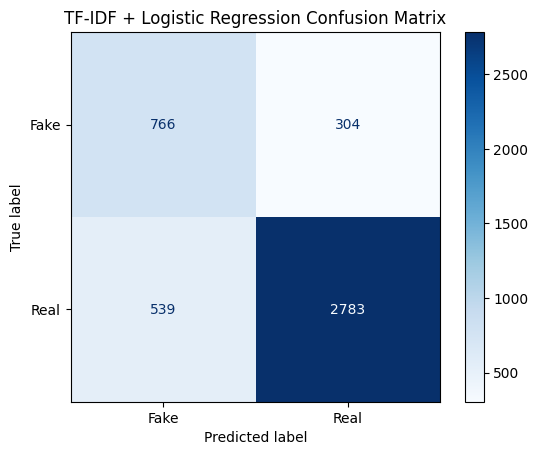


Top words predicting REAL news:
['best' 'season' 'awards' 'celebrates' 'beauty' 'style' 'shares' 'cardi'
 'dress' 'reveals' 'transcript' 'fan' 'bell' 'bachelor' 'thanks']

Top words predicting FAKE news:
['breaking' 'trump' 'react' 'caitlyn' 'brad' 'kanye' 'report' 'jenner'
 'pattinson' 'jennifer' 'pitt' 'beyonce' 'politifact' 'rihanna'
 'brad pitt']


In [12]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# -----------------------------
# 1. Text preprocessing
# -----------------------------
def clean_text(text):
    """
    Clean and normalize news text:
    - remove URLs, mentions, special chars
    - lowercase all text
    """
    text = re.sub(r"http\S+", "", text)             # remove URLs
    text = re.sub(r"@\w+", "", text)                # remove mentions
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)    # keep alphanumeric and spaces
    text = re.sub(r"\s+", " ", text)                # normalize whitespace
    return text.strip().lower()

# Combine title + body and clean
X_train = (train.iloc[:,0] + " " + train.iloc[:,1]).fillna("").apply(clean_text)
X_test  = (test.iloc[:,0] + " " + test.iloc[:,1]).fillna("").apply(clean_text)
y_train, y_test = train["label"], test["label"]

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
tfidf = TfidfVectorizer(
    ngram_range=(1,3),        # unigrams, bigrams, trigrams
    min_df=3,                 # ignore rare words
    max_df=0.9,               # ignore extremely common ones
    max_features=100000,      # expand vocabulary
    sublinear_tf=True,        # log-scale term frequency
    stop_words="english"      # remove stopwords
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

print(f"TF-IDF matrix: {X_train_vec.shape[0]} docs, {X_train_vec.shape[1]} features")

# -----------------------------
# 3. Logistic Regression
# -----------------------------
clf = LogisticRegression(
    C=2,                      # slightly less regularization than default
    max_iter=300,
    class_weight="balanced",
    solver="liblinear"
)

clf.fit(X_train_vec, y_train)
pred = clf.predict(X_test_vec)

# -----------------------------
# 4. Evaluation
# -----------------------------
print("=== TF-IDF Test Classification Report ===")
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("TF-IDF + Logistic Regression Confusion Matrix")
plt.show()

# -----------------------------
# 5. Feature Importance (Top Words)
# -----------------------------
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

top_real = np.argsort(coefs)[-15:]
top_fake = np.argsort(coefs)[:15]

print("\nTop words predicting REAL news:")
print(feature_names[top_real][::-1])

print("\nTop words predicting FAKE news:")
print(feature_names[top_fake])


## 3. Advanced Model: DistilBERT Transformer

### Model Implementation

In [9]:
import accelerate
from accelerate import Accelerator as HFAccelerator
import transformers.trainer as trainer_mod

class PatchedAccelerator(HFAccelerator):
    def __init__(self, *args, dispatch_batches=None, split_batches=None, **kwargs):
        # ignore the new args and just call the original Accelerator
        super().__init__(*args, **kwargs)

# make Trainer use our patched class
trainer_mod.Accelerator = PatchedAccelerator



In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# --- 1. Prepare text and labels ---
def prepare_text(df):
    # Combine title and body into one string
    df["text"] = (df.iloc[:,0].fillna("") + " " + df.iloc[:,1].fillna("")).str.strip()
    return df[["text", "label"]]

train_df = prepare_text(train.copy())
val_df   = prepare_text(val.copy())
test_df  = prepare_text(test.copy())

# --- 2. Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

# --- 3. Convert to Hugging Face Datasets ---
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# --- 4. Load model ---
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# --- 5. Training arguments ---
args = TrainingArguments(
    output_dir="./models",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)

# --- 6. Trainer setup ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
)

# --- 7. Train ---
trainer.train()


/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/15293 [00:00<?, ? examples/s]

Map:   0%|          | 0/2163 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.334100,0.440207
2,0.269400,0.496847
3,0.261800,0.582744


/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=5736, training_loss=0.31862232134764495, metrics={'train_runtime': 2212.1481, 'train_samples_per_second': 20.74, 'train_steps_per_second': 2.593, 'total_flos': 3038735891469312.0, 'train_loss': 0.31862232134764495, 'epoch': 3.0})

### Evaluation

In [11]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Predict on test set
test_results = trainer.predict(test_ds)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

print("=== BERT Test Classification Report ===")
print(classification_report(test_labels, test_preds, digits=3))

# Macro-F1 explicitly
macro_f1 = f1_score(test_labels, test_preds, average='macro')
print("Macro-F1:", macro_f1)

/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


=== BERT Test Classification Report ===
              precision    recall  f1-score   support

           0      0.720     0.642     0.679      1070
           1      0.889     0.920     0.904      3322

    accuracy                          0.852      4392
   macro avg      0.804     0.781     0.791      4392
weighted avg      0.848     0.852     0.849      4392

Macro-F1: 0.7913499543934326


## 4. Cross-Domain Evaluation

In [21]:
df["text"] = df["title"].astype(str).apply(clean_text)
pf = df[df["domain"] == "politifact"].reset_index(drop=True)
gc = df[df["domain"] == "gossipcop"].reset_index(drop=True)

print(len(pf), "PolitiFact samples")
print(len(gc), "GossipCop samples")

985 PolitiFact samples
20863 GossipCop samples


### TF-IDF Cross-Domain

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Train on PF, test on GC
X_train = pf["text"]
y_train = pf["label"]

X_test = gc["text"]
y_test = gc["label"]

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    stop_words="english"
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

clf = LogisticRegression(
    C=2,
    max_iter=300,
    class_weight="balanced",
    solver="liblinear"
)
clf.fit(X_train_vec, y_train)

pred = clf.predict(X_test_vec)

print("=== TF-IDF Cross-Domain: Train PF → Test GC ===")
print(classification_report(y_test, pred, digits=3))

macro_f1_pf_gc = f1_score(y_test, pred, average="macro")
print("Macro-F1:", macro_f1_pf_gc)


=== TF-IDF Cross-Domain: Train PF → Test GC ===
              precision    recall  f1-score   support

           0      0.199     0.226     0.211      4896
           1      0.752     0.721     0.736     15967

    accuracy                          0.605     20863
   macro avg      0.476     0.473     0.474     20863
weighted avg      0.622     0.605     0.613     20863

Macro-F1: 0.47392027723598495


### BERT Cross-Domain

#### Dataset Preparation and Tokenization

In [27]:
pf_ds = Dataset.from_pandas(pf[["text", "label"]])
gc_ds = Dataset.from_pandas(gc[["text", "label"]])

pf_tok = pf_ds.map(tokenize_fn, batched=True)
gc_tok = gc_ds.map(tokenize_fn, batched=True)

pf_tok = pf_tok.rename_column("label", "labels")
gc_tok = gc_tok.rename_column("label", "labels")

pf_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
gc_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/985 [00:00<?, ? examples/s]

Map:   0%|          | 0/20863 [00:00<?, ? examples/s]

#### Train on PolitiFact, Test on GossipCop

In [28]:
model_pf = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

args_pf = TrainingArguments(
    output_dir="./bert_pf",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="no",
)

trainer_pf = Trainer(
    model=model_pf,
    args=args_pf,
    train_dataset=pf_tok,
    tokenizer=tokenizer
)

trainer_pf.train()

gc_pred = trainer_pf.predict(gc_tok)
gc_preds = np.argmax(gc_pred.predictions, axis=1)
gc_labels = gc_pred.label_ids

print("=== BERT Cross-Domain: Train PF → Test GC ===")
print(classification_report(gc_labels, gc_preds, digits=3))
print("Macro-F1:", f1_score(gc_labels, gc_preds, average="macro"))

/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


=== BERT Cross-Domain: Train PF → Test GC ===
              precision    recall  f1-score   support

           0      0.242     0.820     0.374      4896
           1      0.795     0.214     0.337     15967

    accuracy                          0.356     20863
   macro avg      0.519     0.517     0.355     20863
weighted avg      0.665     0.356     0.345     20863

Macro-F1: 0.3554008707837225


#### Train on GossipCop, Test on PolitiFact

In [29]:
model_gc = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

args_gc = TrainingArguments(
    output_dir="./bert_gc",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="no",
)

trainer_gc = Trainer(
    model=model_gc,
    args=args_gc,
    train_dataset=gc_tok,
    tokenizer=tokenizer
)

trainer_gc.train()

pf_pred = trainer_gc.predict(pf_tok)
pf_preds = np.argmax(pf_pred.predictions, axis=1)
pf_labels = pf_pred.label_ids

print("=== BERT Cross-Domain: Train GC → Test PF ===")
print(classification_report(pf_labels, pf_preds, digits=3))
print("Macro-F1:", f1_score(pf_labels, pf_preds, average="macro"))


/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.449000
1000,0.396000
1500,0.390500
2000,0.390400
2500,0.372100
3000,0.332700
3500,0.296800
4000,0.319900
4500,0.291600
5000,0.331400


/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


=== BERT Cross-Domain: Train GC → Test PF ===
              precision    recall  f1-score   support

           0      0.396     0.437     0.416       428
           1      0.530     0.488     0.508       557

    accuracy                          0.466       985
   macro avg      0.463     0.463     0.462       985
weighted avg      0.472     0.466     0.468       985

Macro-F1: 0.4619833852544133
